In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import root_mean_squared_error

from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

plt.rcParams["figure.figsize"] = (8,5)
np.random.seed(42)

print("Setup complete.")


Setup complete.


In [ ]:
df = pd.read_csv("/content/controlled_synthetic_housing.csv")

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (8000, 7)


,area_sqft,bedrooms,bathrooms,distance_city_km,age_years,location_score,price
0,1573.8,2,3,0.50,13.8,7,3677778.0
1,1351.6,5,2,7.64,16.5,5,2962167.0
2,1626.7,5,2,9.01,2.8,4,3511495.0
3,1933.1,4,1,14.31,11.8,4,3994347.0
4,1318.0,5,1,3.01,6.1,5,3071694.0


In [ ]:
X = df.drop(columns=["price"])
y = df["price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (6000, 6)
Test size: (2000, 6)


In [ ]:
models = {
    "Linear": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]),

    "Tree": DecisionTreeRegressor(
        max_depth=6, random_state=42
    ),

    "Forest": RandomForestRegressor(
        n_estimators=200,
        max_depth=8,
        random_state=42
    ),

    "SVM": Pipeline([
        ("scaler", StandardScaler()),
        ("model", SVR(C=50, gamma="scale"))
    ]),

    "Bayesian": Pipeline([
        ("scaler", StandardScaler()),
        ("model", BayesianRidge())
    ])
}

print("Models defined:", list(models.keys()))


Models defined: ['Linear', 'Tree', 'Forest', 'SVM', 'Bayesian']


In [ ]:
predictions = {}
metrics = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    predictions[name] = y_pred

    metrics[name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": root_mean_squared_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred)
    }

metrics_df = pd.DataFrame(metrics).T
metrics_df


,MAE,RMSE,R2
Linear,98480.630260,122441.354057,0.969818
Tree,136955.919714,170790.292950,0.941276
Forest,111919.628631,138593.714975,0.961330
SVM,551897.472486,692920.738151,0.033379
Bayesian,98481.404472,122441.650267,0.969818


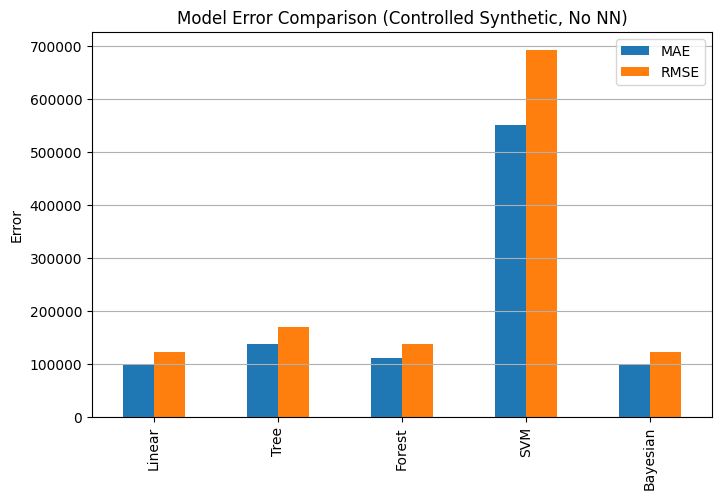

In [ ]:
metrics_df[["MAE","RMSE"]].plot(kind="bar")
plt.title("Model Error Comparison (Controlled Synthetic, No NN)")
plt.ylabel("Error")
plt.grid(axis="y")
plt.show()


In [ ]:
pred_matrix = np.vstack(list(predictions.values()))
disagreement = np.var(pred_matrix, axis=0)

print("Disagreement variance computed.")


Disagreement variance computed.


In [ ]:
# threshold = top 25% disagreement
threshold = np.percentile(disagreement, 75)

mean_pred = np.mean(pred_matrix, axis=0)

disagreement_rank = np.sum(
    np.abs(pred_matrix - mean_pred) > threshold,
    axis=0
)

rank_counts = pd.Series(disagreement_rank).value_counts().sort_index()
rank_counts


,count
0,2000


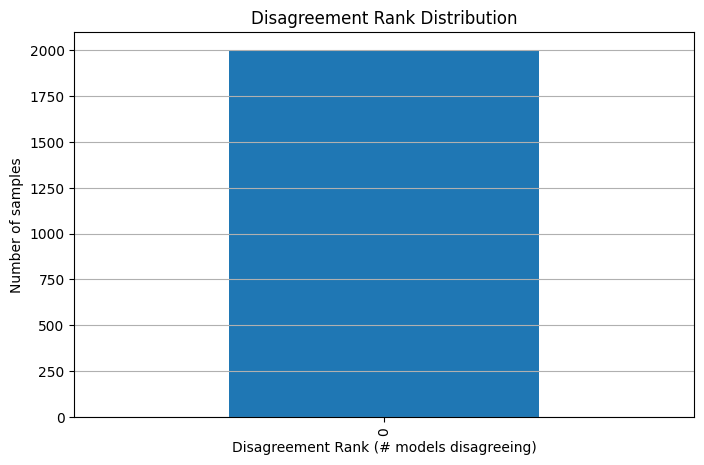

In [ ]:
rank_counts.plot(kind="bar")
plt.xlabel("Disagreement Rank (# models disagreeing)")
plt.ylabel("Number of samples")
plt.title("Disagreement Rank Distribution")
plt.grid(axis="y")
plt.show()


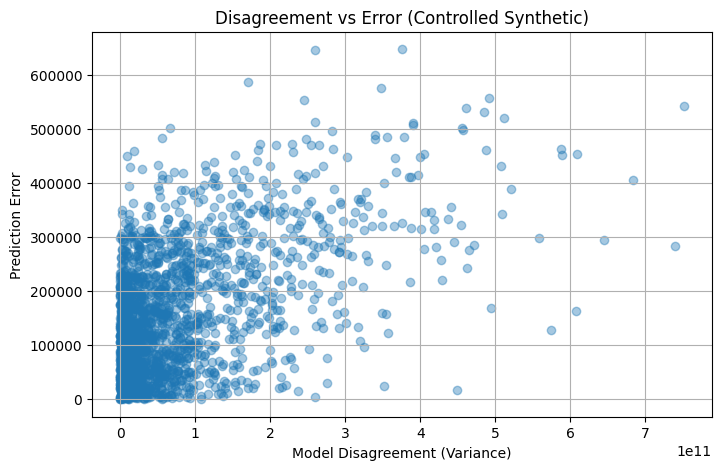

In [ ]:
avg_prediction = np.mean(pred_matrix, axis=0)
absolute_error = np.abs(avg_prediction - y_test.values)

plt.scatter(disagreement, absolute_error, alpha=0.4)
plt.xlabel("Model Disagreement (Variance)")
plt.ylabel("Prediction Error")
plt.title("Disagreement vs Error (Controlled Synthetic)")
plt.grid()
plt.show()


In [ ]:
# define high-error threshold
error_threshold = np.percentile(absolute_error, 75)

error_sets = {}
for name, preds in predictions.items():
    error_sets[name] = set(
        np.where(np.abs(preds - y_test.values) > error_threshold)[0]
    )

# overlap matrix
overlap_matrix = pd.DataFrame(
    index=error_sets.keys(),
    columns=error_sets.keys()
)

for m1 in error_sets:
    for m2 in error_sets:
        overlap_matrix.loc[m1, m2] = len(
            error_sets[m1].intersection(error_sets[m2])
        )

overlap_matrix


,Linear,Tree,Forest,SVM,Bayesian
Linear,133,79,89,102,133
Tree,79,375,157,289,79
Forest,89,157,202,160,89
SVM,102,289,160,1474,102
Bayesian,133,79,89,102,133


In [ ]:
top_idx = np.argsort(disagreement)[-5:]

print("Top 5 High-Disagreement Samples:\n")
for idx in top_idx:
    print("True Price:", round(y_test.values[idx],2))
    for i, model_name in enumerate(predictions.keys()):
        print(f"  {model_name}: {round(pred_matrix[i, idx],2)}")
    print("-"*45)


Top 5 High-Disagreement Samples:

True Price: 1081919.0
  Linear: 1062793.11
  Tree: 1321089.38
  Forest: 1143660.17
  SVM: 3083327.17
  Bayesian: 1062855.42
---------------------------------------------
True Price: 5017463.0
  Linear: 5138608.74
  Tree: 5161068.93
  Forest: 5060179.17
  SVM: 3119955.52
  Bayesian: 5138547.11
---------------------------------------------
True Price: 5172217.0
  Linear: 5151778.73
  Tree: 5161068.93
  Forest: 5255465.19
  SVM: 3116606.19
  Bayesian: 5151715.42
---------------------------------------------
True Price: 5119517.0
  Linear: 5292747.26
  Tree: 5161068.93
  Forest: 5311515.58
  SVM: 3118932.2
  Bayesian: 5292680.19
---------------------------------------------
True Price: 5390105.0
  Linear: 5345942.6
  Tree: 5161068.93
  Forest: 5265121.53
  SVM: 3119720.24
  Bayesian: 5345873.7
---------------------------------------------
